<a href="https://colab.research.google.com/github/Marrie05/RhombixTechnologies_Tasks/blob/main/Sales_Forecasting_for_a_Retail_Store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load & Prepare Data

In [11]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# Paste the copied path here
file_path = '/content/drive/MyDrive/train.csv'
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'])

# Select one store (simplifies modeling)
store_df = df[df['Store'] == 1]

# Aggregate weekly sales
store_df = store_df.groupby('Date')['Weekly_Sales'].sum().reset_index()

store_df = store_df.sort_values('Date')
store_df.head()

Mounted at /content/drive


,Date,Weekly_Sales
0,2010-02-05,1643690.90
1,2010-02-12,1641957.44
2,2010-02-19,1611968.17
3,2010-02-26,1409727.59
4,2010-03-05,1554806.68


Handle Missing + Set Index

Train/Test Split (time-aware)

In [12]:
store_df.set_index('Date', inplace=True)

# Fill missing values if any
store_df['Weekly_Sales'] = store_df['Weekly_Sales'].interpolate()

train = store_df.iloc[:-20]
test = store_df.iloc[-20:]

ARIMA Model

In [13]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['Weekly_Sales'], order=(5,1,2))
fit = model.fit()

arima_forecast = fit.forecast(steps=len(test))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters 

Prophet Model

Prophet needs columns named ds (date) and y (target):

In [14]:
from prophet import Prophet

prophet_df = store_df.reset_index().rename(
    columns={'Date':'ds','Weekly_Sales':'y'}
)

m = Prophet()
m.fit(prophet_df[:-20])

future = m.make_future_dataframe(periods=20, freq='W')
forecast = m.predict(future)

prophet_forecast = forecast.tail(20)['yhat'].values

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LSTM (optional advanced)

Scale + create sequences.

In [15]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

values = store_df['Weekly_Sales'].values.reshape(-1,1)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

def make_seq(data, window=10):
    X,y = [],[]
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X, y = make_seq(scaled)

split = len(X)-20
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm = Sequential([
    LSTM(64, input_shape=(X_train.shape[1],1)),
    Dense(1)
])

lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

lstm_pred_scaled = lstm.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_pred_scaled)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Compare Models

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test['Weekly_Sales'].values

def evaluate(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    print(f"{name}  -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

evaluate(y_true, arima_forecast, "ARIMA")
evaluate(y_true, prophet_forecast, "Prophet")
evaluate(y_true, lstm_forecast.flatten(), "LSTM")

ARIMA  -> MAE: 92942.13, RMSE: 107030.80
Prophet  -> MAE: 59441.93, RMSE: 77127.47
LSTM  -> MAE: 69368.58, RMSE: 81847.22


Visualization

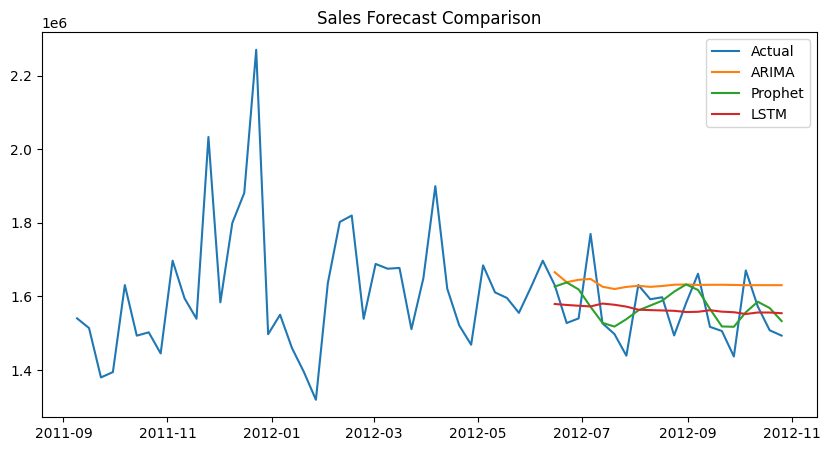

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(store_df.index[-60:], store_df['Weekly_Sales'][-60:], label="Actual")
plt.plot(test.index, arima_forecast, label="ARIMA")
plt.plot(test.index, prophet_forecast, label="Prophet")
plt.plot(test.index, lstm_forecast, label="LSTM")
plt.legend()
plt.title("Sales Forecast Comparison")
plt.show()